In [1]:
pip install pycaret

  Obtaining dependency information for pycaret from https://files.pythonhosted.org/packages/3e/6f/b3d59fac3869a7685e68aecdd35c336800bce8c8d3b45687bb82cf9a2848/pycaret-3.3.2-py3-none-any.whl.metadata
  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for scikit-learn>1.4.0 from https://files.pythonhosted.org/packages/5d/55/0403bf2031250ac982c8053397889fbc5a3a2b3798b913dae4f51c3af6a4/scikit_learn-1.5.1-cp311-cp311-win_amd64.whl.metadata
  Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl.metadata (12 kB)
  Using cached pyod-2.0.1-py3-none-any.whl
  Obtaining dependency information for imbalanced-learn>=0.12.0 from https://files.pythonhosted.org/packages/5a/fa/267de06c95210580f4b82b45cec1ce1e9ce1f21a01a684367db89e7da70d/imbalanced_learn-0.12.3-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
  Obtaining dependency information for category-encoders>=2.4.0 from https://files.pythonhoste

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [4]:
# PyCaret 설치 (이미 설치되어 있으면 이 부분은 생략)
# !pip install pycaret

# 필요한 라이브러리 임포트
from pycaret.classification import *
import pandas as pd

# 데이터셋 로드 (파일 경로를 적절히 설정)
df = pd.read_csv('./train (5).csv')

In [6]:
df=df.drop(columns='ID',axis =1)

In [16]:
import numpy as np

### 파생변수 추가

######  **보험 청구 시점의 경제적 상황**

(https://www.wnsdecisionpoint.com/our-insights/reports/detail/47/insurance-fraud-detection-and-prevention-in-the-era-of-big-data)

**1. income_to_age_group_mean (연령대 대비 보유 소득 비율)**

해당 연령대의 평균 소득에 비해 얼마나 자산을 가지고 있는지 

In [7]:
# Define age groups
bins = [0, 20, 30, 40, 50, 60, 70, 100]
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70+']
df['age_group'] = pd.cut(df['age_of_driver'], bins=bins, labels=labels, right=False)

# Calculate mean income per age group
mean_income_per_age_group = df.groupby('age_group')['annual_income'].mean().to_dict()

# Create a new column for income to age group mean income ratio
df['income_to_age_group_mean'] = df.apply(
    lambda row: row['annual_income'] / mean_income_per_age_group[row['age_group']], axis=1
)

# Show the first few rows to confirm
df[['age_of_driver', 'age_group', 'annual_income', 'income_to_age_group_mean']].head()


,age_of_driver,age_group,annual_income,income_to_age_group_mean
0,33,30-39,35113.78,0.985538
1,44,40-49,38096.04,0.999059
2,29,20-29,33753.00,1.033729
3,33,30-39,35100.61,0.985168
4,51,50-59,39609.60,0.987488


**2. Income to Vehicle Value Ratio (소득 대비 차량 가치)**

소득에 비해 고가 차량으로 사고를 내어 높은 보험금을 노릴 수도 있음

In [89]:
df['income_to_vehicle_value_ratio'] = df['annual_income'] / df['vehicle_price']

**3. payout_vs_avg**

과실 비율에 따른 평균 지급된 보험금 비율보다 얼마나 적게/많게 받았는지 알 수 있는 변수

In [91]:
import pandas as pd

# 1. 과실 비율 범주화
bins = [0, 20, 40, 60, 80, 100]  # 과실 비율을 0-20%, 20-40%, ... 80-100%로 구간화
labels = ['0-20%', '21-40%', '41-60%', '61-80%', '81-100%']
df['liab_prct_category'] = pd.cut(df['liab_prct'], bins=bins, labels=labels, right=False)

# 2. 범주별 평균 보험금 지급 비율 계산
avg_payout_by_category = df.groupby('liab_prct_category')['claim_est_payout'].mean()

# 3. 각 청구에 대한 평균 보험금 지급 비율을 데이터프레임에 추가
df['avg_claim_est_payout'] = df['liab_prct_category'].map(avg_payout_by_category)

# 4. avg_claim_est_payout을 숫자형(float)으로 변환
df['avg_claim_est_payout'] = df['avg_claim_est_payout'].astype(float)

# 5. 각 청구에 대해 실제 보험금 지급 비율과 평균의 차이를 계산
df['payout_vs_avg'] = df['claim_est_payout'] - df['avg_claim_est_payout']

# 결과 확인
df[['liab_prct', 'liab_prct_category', 'claim_est_payout', 'avg_claim_est_payout', 'payout_vs_avg']].head()


,liab_prct,liab_prct_category,claim_est_payout,avg_claim_est_payout,payout_vs_avg
0,42,41-60%,2748.61,5084.758337,-2336.148337
1,98,81-100%,6399.10,5113.103811,1285.996189
2,1,0-20%,4639.07,4978.289068,-339.219068
3,41,41-60%,3698.98,5084.758337,-1385.778337
4,98,81-100%,2084.32,5113.103811,-3028.783811


######  **반복적인 사고 청구**

(https://www.wnsdecisionpoint.com/our-insights/reports/detail/47/insurance-fraud-detection-and-prevention-in-the-era-of-big-data)

**4. Claim Frequency Factor (청구 빈도 지수)**

과거 보험 청구 건수 / 차량 연식 : 차량 연식이 짧은데 보험 청구 건수가 많을 수도 있음 

In [92]:
df['claim_frequency_factor'] = df['past_num_of_claims'] / df['age_of_vehicle']

기존의 수치형을 범주로 나누는 이유? 

### 불필요한 변수 제거 

In [93]:
df=df.drop(columns=['ID','age_group','avg_claim_est_payout','liab_prct_category'],axis =1)

### 여러 전처리 조합 + pycaret

In [67]:
df.to_csv("./df.csv")

In [94]:
# Convert the relevant columns to their appropriate data types

# Convert 'ind' columns to categorical types
df['gender'] = df['gender'].astype('category')
df['marital_status'] = df['marital_status'].astype('category')
df['high_education_ind'] = df['high_education_ind'].astype('category')
df['address_change_ind'] = df['address_change_ind'].astype('category')
df['living_status'] = df['living_status'].astype('category')
df['claim_day_of_week'] = df['claim_day_of_week'].astype('category')
df['accident_site'] = df['accident_site'].astype('category')
df['witness_present_ind'] = df['witness_present_ind'].astype('category')
df['channel'] = df['channel'].astype('category')
df['policy_report_filed_ind'] = df['policy_report_filed_ind'].astype('category')
df['vehicle_category'] = df['vehicle_category'].astype('category')
df['vehicle_color'] = df['vehicle_color'].astype('category')
df['fraud'] = df['fraud'].astype('category')

# Convert numerical columns to the correct numeric types
df['income_to_age_group_mean'] = pd.to_numeric(df['income_to_age_group_mean'])
df['income_to_vehicle_value_ratio'] = pd.to_numeric(df['income_to_vehicle_value_ratio'])
df['payout_vs_avg'] = pd.to_numeric(df['payout_vs_avg'])
df['claim_frequency_factor'] = pd.to_numeric(df['claim_frequency_factor'])

# Display the updated dataframe's dtypes to confirm the changes
df.dtypes


age_of_driver                       int64
gender                           category
marital_status                   category
safty_rating                        int64
annual_income                     float64
high_education_ind               category
address_change_ind               category
living_status                    category
claim_day_of_week                category
accident_site                    category
past_num_of_claims                  int64
witness_present_ind              category
liab_prct                           int64
channel                          category
policy_report_filed_ind          category
claim_est_payout                  float64
age_of_vehicle                    float64
vehicle_category                 category
vehicle_price                     float64
vehicle_color                    category
vehicle_weight                    float64
fraud                            category
year                                int64
month                             

In [96]:
import pandas as pd
from pycaret.classification import setup, compare_models, pull
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import numpy as np

def preprocess_data(data, missing_value_strategy, sampling_strategy, remove_corr_var=True):
    # 1. 결측치 처리
    if missing_value_strategy == 'mean':
        data = data.fillna(data.select_dtypes(include='number').mean())
    elif missing_value_strategy == 'drop':
        data = data.dropna()

    # 2. 범주형 변수 인코딩
    label_encoders = {}
    for column in data.select_dtypes(include=['object', 'category']).columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le

    # 3. 변수 선택 (상관관계 높은 변수 중 하나 제거)
    if remove_corr_var:
        numeric_data = data.select_dtypes(include=['number'])
        corr_matrix = numeric_data.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
        print(to_drop)

        data = data.drop(columns=to_drop)

    # 4. 샘플링 전략 적용
    if sampling_strategy == 'undersampling':
        X = data.drop('fraud', axis=1)
        y = data['fraud']
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X, y)
        data = pd.concat([X_res, y_res], axis=1)
    elif sampling_strategy == 'oversampling':
        X = data.drop('fraud', axis=1)
        y = data['fraud']
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X, y)
        data = pd.concat([X_res, y_res], axis=1)

    return data

def run_pycaret_setup_and_compare(data):
    # PyCaret 환경 설정
    exp_clf = setup(data=data, target='fraud', normalize=True, 
                    normalize_method='minmax', session_id=42)

    # 모델 비교 및 최적 모델 선정
    best_model = compare_models()

    # 최적 모델의 세부 정보 추출
    model_metrics = pull()
    best_model_name = model_metrics.iloc[0]['Model']
    best_precision = model_metrics.iloc[0]['Prec.']
    best_accuracy = model_metrics.iloc[0]['Accuracy']
    best_recall = model_metrics.iloc[0]['Recall']
    best_f1 = model_metrics.iloc[0]['F1']

    return best_model_name, best_precision, best_accuracy, best_recall, best_f1


# 조합 1: 결측치 평균 처리, 언더샘플링, 상관관계 높은 변수 삭제
processed_data_1 = preprocess_data(df.copy(), 'mean', 'undersampling')
result_1 = run_pycaret_setup_and_compare(processed_data_1)

# 조합 2: 결측치 평균 처리, 오버샘플링, 상관관계 높은 변수 삭제
processed_data_2 = preprocess_data(df.copy(), 'mean', 'oversampling')
result_2 = run_pycaret_setup_and_compare(processed_data_2)

# 조합 3: 결측치 행 삭제, 언더샘플링, 상관관계 높은 변수 삭제
processed_data_3 = preprocess_data(df.copy(), 'drop', 'undersampling')
result_3 = run_pycaret_setup_and_compare(processed_data_3)

# 조합 3: 결측치 행 삭제, 오버샘플링, 상관관계 높은 변수 삭제
processed_data_4 = preprocess_data(df.copy(), 'drop', 'oversampling')
result_4 = run_pycaret_setup_and_compare(processed_data_4)

print("Result 1:", result_1)
print("Result 2:", result_2)
print("Result 3:", result_3)


['payout_vs_avg']


,Description,Value
0,Session id,42
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(3942, 28)"
4,Transformed data shape,"(3942, 28)"
5,Transformed train set shape,"(2759, 28)"
6,Transformed test set shape,"(1183, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.6542,0.7120,0.6652,0.6515,0.6579,0.3085,0.3090,0.1430
ada,Ada Boost Classifier,0.6481,0.7094,0.6355,0.6526,0.6436,0.2961,0.2966,0.0520
catboost,CatBoost Classifier,0.6459,0.7110,0.6616,0.6421,0.6515,0.2918,0.2921,0.9490
lda,Linear Discriminant Analysis,0.6412,0.7012,0.6362,0.6434,0.6394,0.2824,0.2828,0.0170
ridge,Ridge Classifier,0.6401,0.7013,0.6355,0.6422,0.6385,0.2802,0.2805,0.0140
lr,Logistic Regression,0.6386,0.7010,0.6355,0.6405,0.6377,0.2773,0.2776,0.6270
lightgbm,Light Gradient Boosting Machine,0.6386,0.7028,0.6457,0.6380,0.6415,0.2773,0.2775,0.3230
rf,Random Forest Classifier,0.6383,0.6936,0.6420,0.6384,0.6397,0.2766,0.2770,0.0820
nb,Naive Bayes,0.6292,0.6860,0.5428,0.6596,0.5939,0.2585,0.2639,0.0170
et,Extra Trees Classifier,0.6249,0.6742,0.6384,0.6230,0.6302,0.2497,0.2501,0.0730


['payout_vs_avg']


,Description,Value
0,Session id,42
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(21254, 28)"
4,Transformed data shape,"(21254, 28)"
5,Transformed train set shape,"(14877, 28)"
6,Transformed test set shape,"(6377, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8940,0.9476,0.8427,0.9392,0.8883,0.7880,0.7923,2.7510
lightgbm,Light Gradient Boosting Machine,0.8923,0.9470,0.8418,0.9365,0.8866,0.7846,0.7888,0.2860
rf,Random Forest Classifier,0.8835,0.9446,0.8486,0.9124,0.8793,0.7670,0.7690,0.3680
gbc,Gradient Boosting Classifier,0.8752,0.9383,0.8439,0.9004,0.8711,0.7504,0.7520,0.8650
et,Extra Trees Classifier,0.8655,0.9344,0.8474,0.8793,0.8630,0.7310,0.7315,0.2100
ada,Ada Boost Classifier,0.8527,0.9256,0.8572,0.8498,0.8534,0.7055,0.7056,0.1990
qda,Quadratic Discriminant Analysis,0.8088,0.8837,0.8281,0.7974,0.8124,0.6175,0.6180,0.0220
lda,Linear Discriminant Analysis,0.8012,0.8775,0.8103,0.7960,0.8030,0.6023,0.6026,0.0290
ridge,Ridge Classifier,0.8002,0.8773,0.8109,0.7942,0.8023,0.6003,0.6006,0.0190
lr,Logistic Regression,0.8001,0.8769,0.8059,0.7969,0.8013,0.6002,0.6004,0.0270


['payout_vs_avg']


,Description,Value
0,Session id,42
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(3798, 28)"
4,Transformed data shape,"(3798, 28)"
5,Transformed train set shape,"(2658, 28)"
6,Transformed test set shape,"(1140, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.6501,0.7038,0.6456,0.6524,0.6486,0.3002,0.3006,0.0570
lr,Logistic Regression,0.6479,0.6981,0.6448,0.6488,0.6465,0.2957,0.2960,0.0160
ridge,Ridge Classifier,0.6471,0.6980,0.6418,0.6486,0.6449,0.2942,0.2945,0.0140
gbc,Gradient Boosting Classifier,0.6471,0.7036,0.6659,0.6431,0.6537,0.2942,0.2950,0.1630
lda,Linear Discriminant Analysis,0.6464,0.6975,0.6433,0.6471,0.6450,0.2927,0.2929,0.0120
catboost,CatBoost Classifier,0.6441,0.7050,0.6523,0.6429,0.6471,0.2882,0.2886,1.0360
nb,Naive Bayes,0.6317,0.6689,0.5839,0.6459,0.6128,0.2634,0.2649,0.0130
et,Extra Trees Classifier,0.6283,0.6771,0.6328,0.6275,0.6297,0.2566,0.2570,0.0790
lightgbm,Light Gradient Boosting Machine,0.6272,0.6836,0.6388,0.6254,0.6315,0.2544,0.2548,0.2600
rf,Random Forest Classifier,0.6257,0.6801,0.6306,0.6251,0.6275,0.2513,0.2515,0.1060


['payout_vs_avg']


,Description,Value
0,Session id,42
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(20362, 28)"
4,Transformed data shape,"(20362, 28)"
5,Transformed train set shape,"(14253, 28)"
6,Transformed test set shape,"(6109, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8943,0.9467,0.8438,0.9387,0.8887,0.7887,0.7928,0.3610
catboost,CatBoost Classifier,0.8923,0.9473,0.8436,0.9347,0.8867,0.7846,0.7885,3.8260
rf,Random Forest Classifier,0.8854,0.9450,0.8487,0.9159,0.8809,0.7707,0.7730,0.4080
gbc,Gradient Boosting Classifier,0.8748,0.9370,0.8489,0.8954,0.8715,0.7497,0.7508,0.8980
et,Extra Trees Classifier,0.8699,0.9353,0.8489,0.8864,0.8671,0.7398,0.7407,0.2510
ada,Ada Boost Classifier,0.8513,0.9252,0.8548,0.8489,0.8517,0.7025,0.7027,0.2090
qda,Quadratic Discriminant Analysis,0.8145,0.8893,0.8336,0.8033,0.8179,0.6290,0.6299,0.0240
nb,Naive Bayes,0.8033,0.8789,0.8238,0.7915,0.8072,0.6065,0.6073,0.0230
dt,Decision Tree Classifier,0.8032,0.8032,0.8169,0.7952,0.8058,0.6064,0.6067,0.0570
lda,Linear Discriminant Analysis,0.8025,0.8793,0.8172,0.7940,0.8053,0.6050,0.6054,0.0270


Result 1: ('Gradient Boosting Classifier', 0.6515, 0.6542, 0.6652, 0.6579)
Result 2: ('CatBoost Classifier', 0.9392, 0.894, 0.8427, 0.8883)
Result 3: ('Ada Boost Classifier', 0.6524, 0.6501, 0.6456, 0.6486)


#### 변수 중요도 

,Description,Value
0,Session id,42
1,Target,fraud
2,Target type,Binary
3,Original data shape,"(21254, 28)"
4,Transformed data shape,"(21254, 28)"
5,Transformed train set shape,"(14877, 28)"
6,Transformed test set shape,"(6377, 28)"
7,Numeric features,27
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8999,0.9474,0.8387,0.9556,0.8933,0.7997,0.8058
1,0.8837,0.9392,0.8266,0.9332,0.8767,0.7675,0.7725
2,0.8905,0.9477,0.8347,0.9395,0.8840,0.7809,0.7858
3,0.9059,0.9517,0.8468,0.9604,0.9000,0.8118,0.8176
4,0.8931,0.9511,0.8427,0.9372,0.8875,0.7863,0.7903
5,0.8810,0.9390,0.8387,0.9163,0.8758,0.7621,0.7648
6,0.9032,0.9590,0.8669,0.9348,0.8996,0.8065,0.8086
7,0.9011,0.9555,0.8454,0.9516,0.8954,0.8023,0.8073
8,0.8904,0.9517,0.8454,0.9291,0.8853,0.7808,0.7840


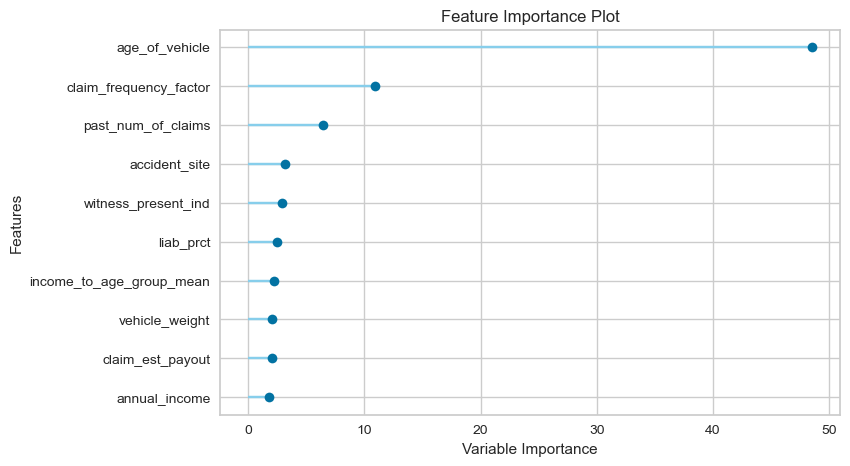

In [82]:
from pycaret.classification import create_model, plot_model

# PyCaret 환경 설정
processed_data_2 = preprocess_data(df.copy(), 'mean', 'oversampling')
exp_clf = setup(data=processed_data_2, target='fraud', normalize=True, 
                normalize_method='minmax', session_id=42)

# CatBoost 모델 생성
catboost_model = create_model('catboost')

# 변수 중요도 시각화
plot_model(catboost_model, plot='feature')

# 변수 중요도 플롯을 출력
plt.show()